In [1]:
import numpy as np
from ctypes import *
import matplotlib.pyplot as plt

from numba import njit
import time

from optic.dsp.core import upsample, pnorm, pulseShape, firFilter, signal_power
from optic.comm.modulation import modulateGray, GrayMapping
from optic.plot import eyediagram

outFile = "/home/silas/Documents/GitHub/TDI/src/dsp.so"
dsp = CDLL(outFile)

# Define uma classe que herda Structure para representação de números complexos.
class Complex(Structure):
    _fields_ = [("real", c_float),
                ("imaginary", c_float)]
    
# define o tipo "np.complex64" para matrizes numpy como parâmetro de entrada
npArrayTypeComplex = np.ctypeslib.ndpointer(dtype=np.complex64, flags="C_CONTIGUOUS")

def tuple2numpy(arr):
    """ 
    Converte um determinada tuple em um array
    numpy, (real, imag) --> np.array
    Args:
        arr (tuple): tuple contendo valores reais e imaginários
    Returns:
        np.array: array numpy de tipo complexo.
    """
    return np.array([complex(x[0], x[1]) for x in arr], dtype=np.complex64)

def c2py(arr, shape):
    """_summary_
    Args:
        arr (class '__main__.LP_Complex'): matriz de conversão para numpy
        shape (int): comprimento do array para 1D
    Returns:
        arr (np.array): matriz do tipo numpy unidimensional.
    """
    arr = np.ctypeslib.as_array(arr, shape=(shape,))
    return tuple2numpy(arr)

In [2]:
# define o detector ML implementado em C
dsp.MLdetector.restype = POINTER(Complex)
dsp.MLdetector.argtypes = [npArrayTypeComplex, npArrayTypeComplex, c_int, c_int]

# Critério de Decisão ML

Para o caso em que os símbolos enviados pelo transmissor são equiprováveis, $P\left({\bf s}_{m}\right)={\frac{1}{M}},\;m=1,2,\ldots,M$, e o critério de decisão MAP pode ser simplificado para:

$$\hat{\mathbf{s}}_{m}=\arg\operatorname*{max}_{\mathbf{s}_{m}}P\left(\mathbf{s}_{m}|\mathbf{r}\right)$$
$$\arg\operatorname*{max}_{\mathbf{s}_{m}}p\left(\mathbf{r}\vert\mathbf{s}_{m}\right)$$

Desse modo, o critério de decisão ótima requer apenas da avaliação da função. Uma vez que esta densidade de probabilidade condicional é conhecida como função de verossimilhança, o novo critério denomina-se critério de máxima verossimilhança.

## Implementação do detector ML em Python

In [3]:
@njit
def detector(r, σ2, constSymb, px=None, rule='MAP'):
    """
    Perform symbol detection using either the MAP (Maximum A Posteriori) or ML (Maximum Likelihood) rule.

    Parameters:
        r (ndarray): The received signal.
        σ2 (float): The noise variance.
        constSymb (ndarray): The constellation symbols.
        px (ndarray, optional): The prior probabilities of each symbol. If None, uniform priors are assumed.
        rule (str, optional): The detection rule to use. Either 'MAP' (default) or 'ML'.

    Returns:
        tuple: A tuple containing:
            - ndarray: The detected symbols.
            - ndarray: The indices of the detected symbols in the constellation.

    """
    if px is None or rule == 'ML':
        px = 1 / constSymb.size * np.ones(constSymb.size)
           
    decided = np.zeros(r.size, dtype=np.complex64) 
    indDec = np.zeros(r.size, dtype=np.int64) 
    π = np.pi  
    
    if rule == 'MAP':
        for ii, ri in enumerate(r): # for each received symbol        
            log_probMetric = np.zeros(constSymb.size)

            # calculate MAP probability metric        
            # calculate log(P(sm|r)) = log(p(r|sm)*P(sm)) for m= 1,2,...,M
            log_probMetric = - np.abs(ri - constSymb)**2 / σ2 + np.log(px)

            # find the constellation symbol with the largest P(sm|r)       
            indDec[ii] = np.argmax(log_probMetric)

            # make the decision in favor of the symbol with the largest metric
            decided[ii] = constSymb[indDec[ii]]
            
    elif rule == 'ML':      
        for ii, ri in enumerate(r): # for each received symbol        
            distMetric = np.zeros(constSymb.size)        
            # calculate distance metric   

            # calculate |r-sm|**2, for m= 1,2,...,M
            distMetric = np.abs(ri - constSymb)**2

            # find the constellation symbol with the smallest distance metric       
            indDec[ii] = np.argmin(distMetric)

            # make the decision in favor of the symbol with the smallest metric
            decided[ii] = constSymb[indDec[ii]]
    else:
        print('Detection rule should be either MAP or ML')
        
    return decided, indDec

## Exemplo: sinal M-QAM equiprovável

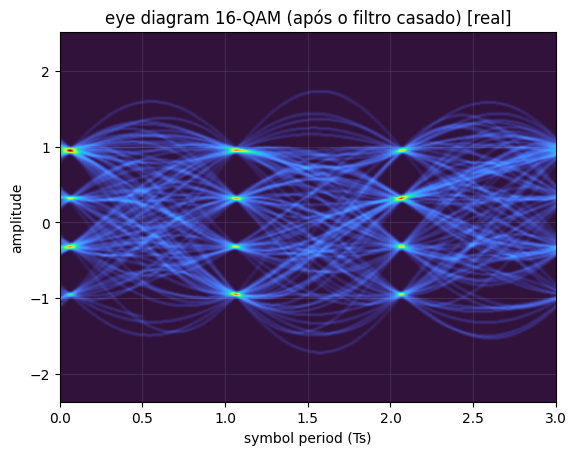

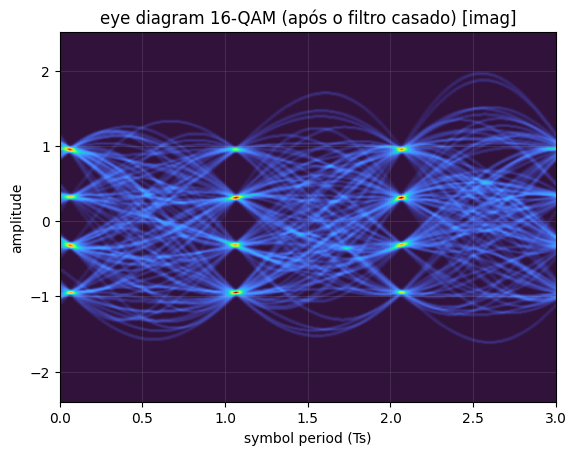

In [4]:
# select QAM order
M = 16

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# get constellation    
constSymb = GrayMapping(M, 'qam')  # constellation
constSymb = np.array(pnorm(constSymb), dtype="complex64")

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(500000*np.log2(M)))

# generate modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'qam')    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('rrc', SpS, N=4096, alpha=0.01)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = pnorm(sigTx)

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.00025 # variância
μ   = 0      # média

σ      = np.sqrt(σ2*SpS) 
ruido  = 1/np.sqrt(2)*(np.random.normal(μ, σ, Namostras) + 1j*np.random.normal(μ, σ, Namostras))

# filtro casado
sigRx = firFilter(pulse, sigTx+ruido)
sigRx = pnorm(sigRx)

# downsampling
r = np.array(sigRx[0::SpS], dtype="complex64")

# diagrama de olho
Nsamples = 200000*SpS
eyediagram(sigRx, Nsamples, SpS, plotlabel= str(M)+'-QAM (após o filtro casado)', ptype='fancy')

/home/silas/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/silas/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


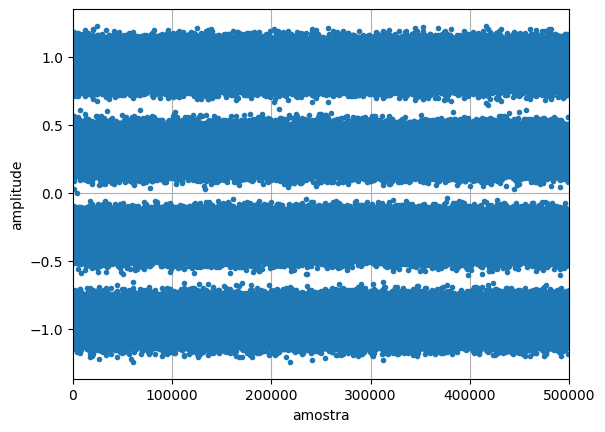

In [5]:
plt.plot(r, ".")
plt.xlabel('amostra')
plt.ylabel('amplitude')
plt.xlim(0, r.size)
plt.grid(True);

## Aplicando o critério de decisão ótima (ML)

In [6]:
# aplica o critério de decisão ótima em C
start_c = time.time()
decision_c = dsp.MLdetector(r, constSymb, constSymb.size, r.size)
end_c = time.time()
decision_c = c2py(decision_c, r.size)

# aplica o critério de decisão ótima em python
start_py = time.time()
decision_py, _ = detector(r, σ2, constSymb, rule='ML')
end_py = time.time()

In [7]:
print(f'tempo de execução para demodulação em C: {round(end_c-start_c, 2)}s')
print(f'tempo de execução para demodulação em Python: {round(end_py-start_py, 2)}s')

tempo de execução para demodulação em C: 0.4s
tempo de execução para demodulação em Python: 2.77s


### Métricas Obtidas em C

In [8]:
ind = np.arange(100,decision_c.size-100)
SER = 1 - np.sum( np.isclose(decision_c[ind], symbTx[ind], rtol=1e-2) )/decision_c.size # calcula SER
SNRb = 10*np.log10(signal_power(sigTx)/σ2/np.log2(M))

print(f'SNRb = {SNRb:.2f} dB')
print(f'SER = {SER:.2e}')

SNRb = 30.00 dB
SER = 4.00e-04


### Métricas Obtidas em Python

In [9]:
ind = np.arange(100,decision_py.size-100)
SER = 1 - np.sum( np.isclose(decision_py[ind], symbTx[ind], rtol=1e-2) )/decision_py.size # calcula SER
SNRb = 10*np.log10(signal_power(sigTx)/σ2/np.log2(M))

print(f'SNRb = {SNRb:.2f} dB')
print(f'SER = {SER:.2e}')

SNRb = 30.00 dB
SER = 4.00e-04


# Variância vs SER

In [ ]:
σ2     = np.linspace(0.00005, 0.05, num=25)
SNRb   = np.zeros(len(σ2))
SER_C  = np.zeros(len(σ2))
SER_PY = np.zeros(len(σ2))

# select QAM order
M = 16

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

for indsigma, sigma2 in enumerate(σ2):
    # get constellation    
    constSymb = GrayMapping(M, 'qam')  # constellation
    constSymb = np.array(pnorm(constSymb), dtype="complex64")

    # generate pseudo-random bit sequence
    bitsTx = np.random.randint(2, size = int(50000*np.log2(M)))

    # generate modulated symbol sequence
    symbTx = modulateGray(bitsTx, M, 'qam')    
    symbTx = pnorm(symbTx) # power normalization

    # upsampling
    symbolsUp = upsample(symbTx, SpS)

    # pulso NRZ típico
    pulse = pulseShape('rrc', SpS, N=4096, alpha=0.01)
    pulse = pulse/max(abs(pulse))

    # formatação de pulso
    sigTx = firFilter(pulse, symbolsUp)
    sigTx = pnorm(sigTx)

    # ruído gaussiano branco
    Namostras = sigTx.size
    σ2  = sigma2 # variância
    μ   = 0      # média

    σ      = np.sqrt(σ2*SpS) 
    ruido  = 1/np.sqrt(2)*(np.random.normal(μ, σ, Namostras) + 1j*np.random.normal(μ, σ, Namostras))

    # filtro casado
    sigRx = firFilter(pulse, sigTx+ruido)
    sigRx = pnorm(sigRx)

    # downsampling
    r = np.array(sigRx[0::SpS], dtype="complex64")

    # aplica o critério de decisão ótima em C
    decision_c = dsp.MLdetector(r, constSymb, constSymb.size, r.size)
    decision_c = c2py(decision_c, r.size)

    ind = np.arange(100,decision_c.size-100)
    SER_C[indsigma] = 1 - np.sum(np.isclose(decision_c[ind], symbTx[ind], rtol=1e-2))/decision_c.size # calcula SER

    # aplica o critério de decisão ótima em python
    decision_py, _ = detector(r, σ2, constSymb, rule='ML')

    ind = np.arange(100,decision_py.size-100)
    SER_PY[indsigma] = 1 - np.sum(np.isclose(decision_py[ind], symbTx[ind], rtol=1e-2))/decision_py.size # calcula SER

    SNRb[indsigma] = 10*np.log10(signal_power(sigTx)/σ2/np.log2(M))

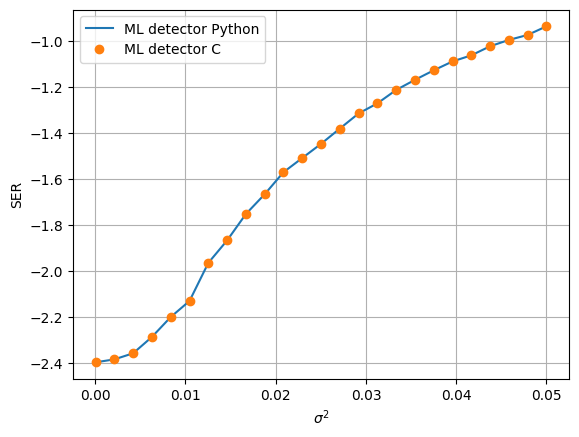

In [ ]:
plt.plot(np.linspace(0.00005, 0.05, num=25), np.log10(SER_PY), label='ML detector Python')
plt.plot(np.linspace(0.00005, 0.05, num=25), np.log10(SER_C), "o", label='ML detector C')
plt.grid(True)
plt.xlabel(r"$\sigma^2$")
plt.ylabel("SER")
plt.legend()

Text(0, 0.5, 'SNRb (dB)')

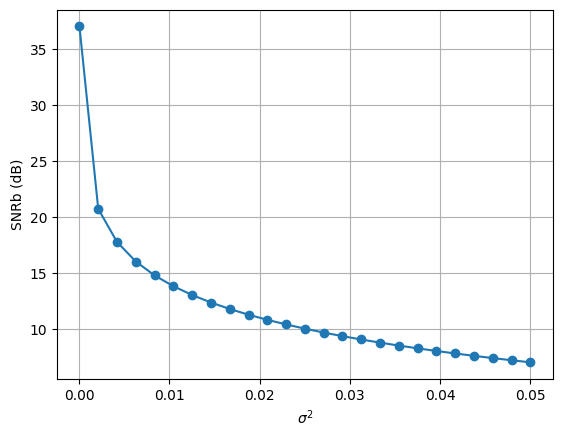

In [ ]:
plt.plot(np.linspace(0.00005, 0.05, num=25), SNRb, "-o")
plt.grid(True)
plt.xlabel(r"$\sigma^2$")
plt.ylabel("SNRb (dB)")